In [1]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


In [0]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [3]:
print(x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


In [0]:
from keras.layers import Input, Dense, Lambda
from keras.models import Model

In [0]:
from keras import backend as K

In [0]:
from keras import losses

In [0]:
batch_size = 128
original_dim = 784
intermediate_dim = 512
latent_dim = 2
epsilon_std = 0.1
epochs = 10

In [8]:
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

W0816 11:17:47.607111 139819522766720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0816 11:17:47.633242 139819522766720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0816 11:17:47.638862 139819522766720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [9]:
def sampling(args):
  z_mean, z_log_sigma = args
  batch = K.shape(z_mean)[0]
  dim = K.int_shape(z_mean)[1]
  epsilon = K.random_normal(shape=(batch, dim))
#   epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=epsilon_std)
  return z_mean + K.exp(z_log_sigma) * epsilon


z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

W0816 11:17:47.707246 139819522766720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.



In [0]:
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [0]:
# end-to-end autoencoder
vae = Model(x, x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [12]:
def vae_loss(x, x_decoded_mean):
    xent_loss = losses.binary_crossentropy(x, x_decoded_mean)
#     return xent_loss
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

vae.compile(optimizer='rmsprop', loss='binary_crossentropy')
# vae.compile(optimizer='rmsprop', loss=vae_loss)

W0816 11:17:47.799823 139819522766720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0816 11:17:47.826225 139819522766720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0816 11:17:47.834489 139819522766720 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 76us/step - loss: 0.2290 - val_loss: 0.2076
Epoch 2/10
60000/60000 [==============================] - 4s 59us/step - loss: 0.2035 - val_loss: 0.1998
Epoch 3/10
60000/60000 [==============================] - 3s 58us/step - loss: 0.1981 - val_loss: 0.1961
Epoch 4/10
60000/60000 [==============================] - 4s 59us/step - loss: 0.1951 - val_loss: 0.1941
Epoch 5/10
60000/60000 [==============================] - 4s 60us/step - loss: 0.1930 - val_loss: 0.1923
Epoch 6/10
60000/60000 [==============================] - 4s 59us/step - loss: 0.1914 - val_loss: 0.1915
Epoch 7/10
60000/60000 [==============================] - 4s 59us/step - loss: 0.1900 - val_loss: 0.1896
Epoch 8/10
60000/60000 [==============================] - 4s 58us/step - loss: 0.1889 - val_loss: 0.1894
Epoch 9/10
60000/60000 [==============================] - 4s 60us/step - loss: 0.1878 - val_loss: 0.1886
Epoch

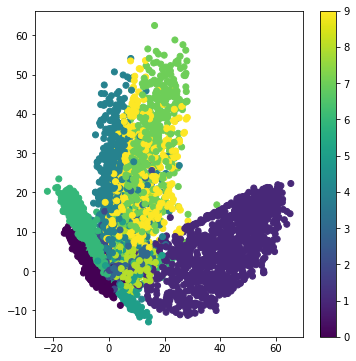

In [14]:
import matplotlib.pyplot as plt

x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

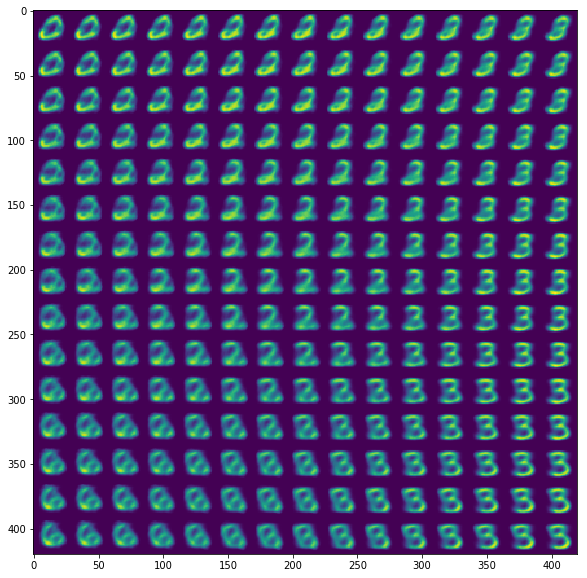

In [15]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * epsilon_std
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()